In [1]:
pip install graphdatascience

Note: you may need to restart the kernel to use updated packages.


In [2]:
from neo4j import GraphDatabase,Result
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken
import numpy as np
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Neo4jVector
from langchain_community.graphs import Neo4jGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from llama_index.core.schema import TextNode
from llama_index.core.vector_stores.utils import node_to_metadata_dict
from llama_index.vector_stores.neo4jvector import Neo4jVectorStore
from llama_index.core import VectorStoreIndex
from tqdm import tqdm

In [3]:
# Replace with the actual URI, username and password
AURA_CONNECTION_URI = "neo4j+s://e8ff9e9e.databases.neo4j.io"
AURA_USERNAME = "neo4j"
AURA_PASSWORD = "At8a_yrym6b6Yljd_Fvv-nENF4vNxSo4A-Vd-3w3YzA"

# Driver instantiation
virtual_driver = GraphDatabase.driver(
    AURA_CONNECTION_URI,
    auth=(AURA_USERNAME, AURA_PASSWORD)
)

In [25]:
## Define a function which executes a Cypher statement on Graph Database and outputs a Pandas Dataframe
def db_query(cypher: str, params: dict[str, any] = {}) -> pd.DataFrame:
    """Executes a Cypher statement and returns a DataFrame"""
    return virtual_driver.execute_query(
        cypher, parameters_=params, result_transformer_=Result.to_df
    )

In [48]:
entity_df_3 = db_query(
    """
MATCH (d:Chunk)
RETURN count {(d)-[:HAS_ENTITY]->()} AS entity_count
ORDER BY entity_count DESC
"""
)

display(entity_df_3.head(100))
print(entity_df_3['entity_count'].mean())


,entity_count
0,41
1,41
2,41
3,41
4,32
...,...
95,8
96,8
97,8
98,8


4.607508532423208


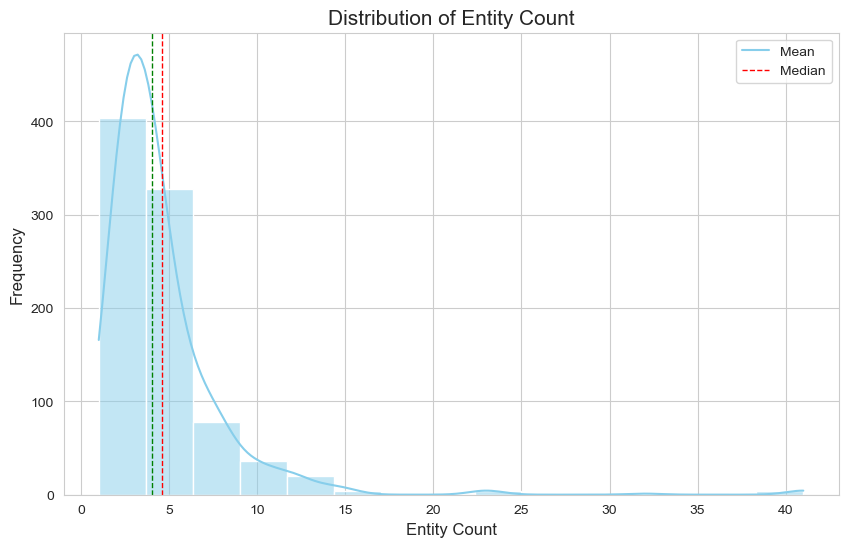

4.607508532423208
4.0


In [7]:
# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(entity_df_3['entity_count'], kde=True, bins=15, color='skyblue')
plt.axvline(entity_df_3['entity_count'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(entity_df_3['entity_count'].median(), color='green', linestyle='dashed', linewidth=1)
plt.xlabel('Entity Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Entity Count', fontsize=15)
plt.legend({'Mean': entity_df_3['entity_count'].mean(), 'Median': entity_df_3['entity_count'].median()})
plt.show()

print(entity_df_3['entity_count'].mean())
print(entity_df_3['entity_count'].median())

In [42]:
degree_dist_df_3 = db_query(
    """
MATCH (n)
OPTIONAL MATCH (n)-[r]-(m)
WHERE NOT (n:Chunk) AND NOT (n:Document) AND NOT (m:Chunk) AND NOT (m:Document)
RETURN n.id, COUNT(r) AS node_degree
ORDER BY node_degree DESC
"""
)

display(degree_dist_df_3.head(100))


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\nMATCH (n)\nOPTIONAL MATCH (n)-[r]-(m)\nWHERE NOT (n:Chunk) AND NOT (n:Document) AND NOT (m:Chunk) AND NOT (m:Document)\nRETURN n.id, COUNT(r) AS node_degree\nORDER BY node_degree DESC\n'


,n.id,node_degree
0,Scrooge,252
1,Ghost,47
2,Spirit,47
3,Bob Cratchit,26
4,Bob,23
...,...,...
95,Master Scrooge,3
96,Contract,3
97,Man,3
98,Master Of The House,2


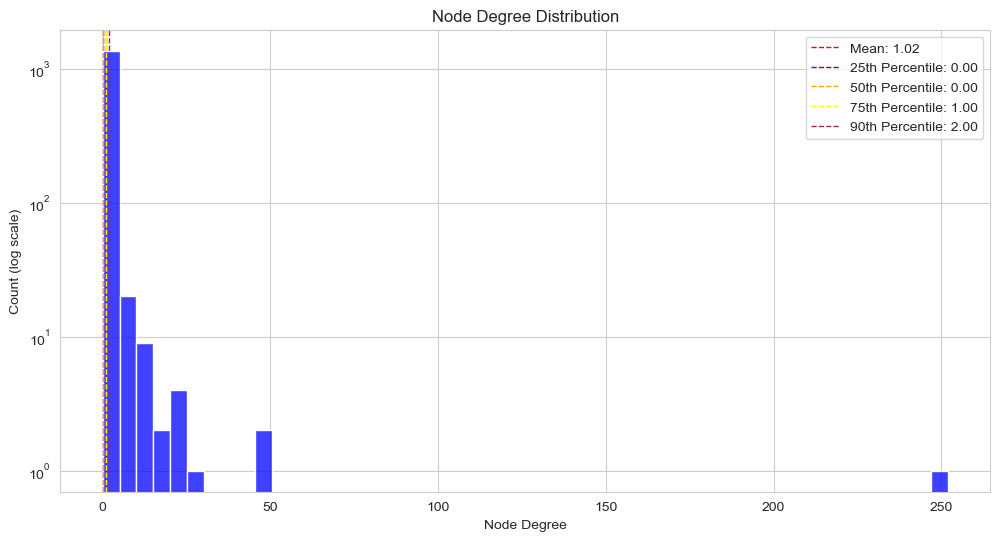

1.0242857142857142
0.0


In [40]:
# Calculate mean and median
mean_degree = np.mean(degree_dist_df_3['node_degree'])
percentiles = np.percentile(degree_dist_df_3['node_degree'], [25, 50, 75, 90])
# Create a histogram with a logarithmic scale
plt.figure(figsize=(12, 6))
sns.histplot(degree_dist_df_3['node_degree'], bins=50, kde=False, color='blue')
# Use a logarithmic scale for the x-axis
plt.yscale('log')
# Adding labels and title
plt.xlabel('Node Degree')
plt.ylabel('Count (log scale)')
plt.title('Node Degree Distribution')
# Add mean, median, and percentile lines
plt.axvline(mean_degree, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_degree:.2f}')
plt.axvline(percentiles[0], color='purple', linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentiles[0]:.2f}')
plt.axvline(percentiles[1], color='orange', linestyle='dashed', linewidth=1, label=f'50th Percentile: {percentiles[1]:.2f}')
plt.axvline(percentiles[2], color='yellow', linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentiles[2]:.2f}')
plt.axvline(percentiles[3], color='brown', linestyle='dashed', linewidth=1, label=f'90th Percentile: {percentiles[3]:.2f}')
# Add legend
plt.legend()
# Show the plot
plt.show()

print(degree_dist_df_3['node_degree'].mean())
print(degree_dist_df_3['node_degree'].median())

In [11]:
db_query("""
  MATCH (n:__Entity__) 
  RETURN n.name AS name, count{(n)-[:RELATED]-()} AS degree
  ORDER BY degree DESC LIMIT 5""")

Failed to write data to connection ResolvedIPv4Address(('34.78.243.29', 7687)) (ResolvedIPv4Address(('34.78.243.29', 7687)))
Failed to write data to connection IPv4Address(('e8ff9e9e.databases.neo4j.io', 7687)) (ResolvedIPv4Address(('34.78.243.29', 7687)))
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name is: __Entity__)} {position: line: 2, column: 12, offset: 12} for query: '\n  MATCH (n:__Entity__) \n  RETURN n.name AS name, count{(n)-[:RELATED]-()} AS degree\n  ORDER BY degree DESC LIMIT 5'


,name,degree
